# Importing from the Dataset

**Importing libraries**

In [1]:
import pandas as pd

**Reading the CSV files downloaded from the "The Weather Database"**

In [2]:
import os

countries_path = os.path.join(os.getcwd(), "dataset/countries.csv")
cities_path = os.path.join(os.getcwd(), "dataset/cities.csv")

countries = pd.read_csv(countries_path)
cities = pd.read_csv(cities_path)

**Reading Parquet Files - approx 10secs to run**

In [3]:
import pyarrow.parquet as pq

daily_weather_path = os.path.join(os.getcwd(), "dataset/daily_weather.parquet")
daily_weather = pd.read_parquet(daily_weather_path)

In [4]:
%%time
daily_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27635763 entries, 0 to 24220
Data columns (total 14 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   station_id              category      
 1   city_name               category      
 2   date                    datetime64[us]
 3   season                  category      
 4   avg_temp_c              float64       
 5   min_temp_c              float64       
 6   max_temp_c              float64       
 7   precipitation_mm        float64       
 8   snow_depth_mm           float64       
 9   avg_wind_dir_deg        float64       
 10  avg_wind_speed_kmh      float64       
 11  peak_wind_gust_kmh      float64       
 12  avg_sea_level_pres_hpa  float64       
 13  sunshine_total_min      float64       
dtypes: category(3), datetime64[us](1), float64(10)
memory usage: 2.6 GB
CPU times: total: 46.9 ms
Wall time: 123 ms


**Checking the database**

In [5]:
#daily_weather.head()

In [6]:
#countries.head()

In [7]:
#cities.head()

# Creating the train and test datasets

**Creating a list with the European cities and their coordinations**

In [5]:
european_countries = countries[countries['continent'] == 'Europe']['iso3'].tolist()
european_cities = cities[cities['iso3'].isin(european_countries)]
cities_list = european_cities[['city_name', 'latitude', 'longitude']].to_dict('records')

**Load the Köppen-Geiger raster map**

In [6]:
import rasterio

raster_path = os.path.join(os.getcwd(), "kopper/Beck_KG_V1_present_0p0083.tif")
raster = rasterio.open(raster_path)

**Function to extract the climate zone for each city**

In [7]:
def get_climate_zone(lat, lon, raster):
    # Transform geographic coordinates to the raster's coordinate system
    coords = rasterio.transform.rowcol(raster.transform, lon, lat)
    # Extract the climate zone value at the given coordinates
    climate_zone = raster.read(1)[coords]
    return climate_zone

**Transforming the climate zones from numbers to their Köppen-Geiger climate types - found in the Matlab file**

In [8]:
# Mapping from numeric climate zone to Köppen-Geiger classification
climate_types_codes = {
    1: 'Af',  # Tropical, rainforest
    2: 'Am',  # Tropical, monsoon
    3: 'Aw',  # Tropical, savannah
    4: 'BWh', # Arid, desert, hot
    5: 'BWk', # Arid, desert, cold
    6: 'BSh', # Arid, steppe, hot
    7: 'BSk', # Arid, steppe, cold
    8: 'Csa', # Temperate, dry summer, hot summer
    9: 'Csb', # Temperate, dry summer, warm summer
    10: 'Csc', # Temperate, dry summer, cold summer
    11: 'Cwa', # Temperate, dry winter, hot summer
    12: 'Cwb', # Temperate, dry winter, warm summer
    13: 'Cwc', # Temperate, dry winter, cold summer
    14: 'Cfa', # Temperate, no dry season, hot summer
    15: 'Cfb', # Temperate, no dry season, warm summer
    16: 'Cfc', # Temperate, no dry season, cold summer
    17: 'Dsa', # Cold, dry summer, hot summer
    18: 'Dsb', # Cold, dry summer, warm summer
    19: 'Dsc', # Cold, dry summer, cold summer
    20: 'Dsd', # Cold, dry summer, very cold winter
    21: 'Dwa', # Cold, dry winter, hot summer
    22: 'Dwb', # Cold, dry winter, warm summer
    23: 'Dwc', # Cold, dry winter, cold summer
    24: 'Dwd', # Cold, dry winter, very cold winter
    25: 'Dfa', # Cold, no dry season, hot summer
    26: 'Dfb', # Cold, no dry season, warm summer
    27: 'Dfc', # Cold, no dry season, cold summer
    28: 'Dfd', # Cold, no dry season, very cold winter
    29: 'ET',  # Polar, tundra
    30: 'EF',  # Polar, frost
}

**Determine the climate zone for each city - approx 5mins to run**

In [9]:
for city in cities_list:
    climate_zone = get_climate_zone(city['latitude'], city['longitude'], raster)
    climate_type = climate_types_codes.get(climate_zone, "Unknown") # Unknown if it does not find the exact climate zone
    city['climate_zone'] = climate_type

**Removing unwanted cities because of their climate type (not enough data)**

In [10]:
unwanted_climate_types = {
    # These can't be found in our database
    'Af', 'Am', 'As', 'Aw', 'Csc', 'Cwb', 'Cwc', 'Dfd', 'Dsa', 'Dsb', 'Dwd', 'EF', 'ET',
    # These can be found but don't have enough data / or they can't be simplified and categorized into our custom categories
    'BSh', 'BSk', 'BWh', 'BWk', 'Cfa', 'Cwa', 'Dsc', 'Dwa', 'Dwb',
    # Errors
    'Unknown'
}

cities_list = [city for city in cities_list if city['climate_zone'] not in unwanted_climate_types]

**Transforming the Köppen-Geiger climate types to our desired simplified climate types**

In [11]:
climate_types_names = {
    # Mediterranean Climate Type
    'Csa': 'Mediterranean', 'Csb': 'Mediterranean',
    # Oceanic Climate Type
    'Cfb': 'Oceanic', 'Cfc': 'Oceanic',
    # Continental Climate Type
    'Dfa': 'Continental', 'Dfb': 'Continental', 'Dfc': 'Continental', 'Dfd': 'Continental', 'Dwc': 'Continental'
}

for city in cities_list:
    city['climate_type'] = climate_types_names.get(city['climate_zone'], 'Unknown') # Unknown if it does not find the exact climate type

**Creating and outputing the desired train and test CSV files - approx 20secs to run**

In [12]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os

# Set the start date to 01/01/2000
start_date = pd.to_datetime('2000-01-01')

# Initialize an empty DataFrame to store all the weather data
all_weather_data = pd.DataFrame()

for city in cities_list:
    desired_city = city['city_name']
    weather_for_city = daily_weather[daily_weather["city_name"] == desired_city]

    # Remove unwanted columns
    columns_to_remove = ['station_id', 'sunshine_total_min', 'snow_depth_mm', 'peak_wind_gust_kmh']
    weather_for_city = weather_for_city.drop(columns=columns_to_remove)

    # Add the climate type column
    weather_for_city['climate_type'] = city['climate_type']

    # Remove data older than 2000
    weather_for_city = weather_for_city[weather_for_city['date'] >= start_date]

    # Drop rows that have at least 4 null values
    weather_for_city = weather_for_city.dropna(thresh=len(weather_for_city.columns) - 3)

    # Append the city's data to the all_weather_data DataFrame
    all_weather_data = pd.concat([all_weather_data, weather_for_city])

# Split the data into training (80%) and testing (20%) sets
train_data, test_data = train_test_split(all_weather_data, test_size=0.2, random_state=42)

# Define the folder path
folder_path = "train-test-datasets"
os.makedirs(folder_path, exist_ok=True)

# Save train and test data to CSV files
train_file_path = os.path.join(folder_path, "train_data.csv")
test_file_path = os.path.join(folder_path, "test_data.csv")

train_data.to_csv(train_file_path, index=False)
test_data.to_csv(test_file_path, index=False)

# Handling missing values

**Reading the saved CSV files**

In [13]:
train_data = pd.read_csv(os.path.join(folder_path, "train_data.csv"))
test_data = pd.read_csv(os.path.join(folder_path, "test_data.csv"))

**Importing libraries for plots**

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

**Heatmap to visualize missing values - approx 10secs to run**

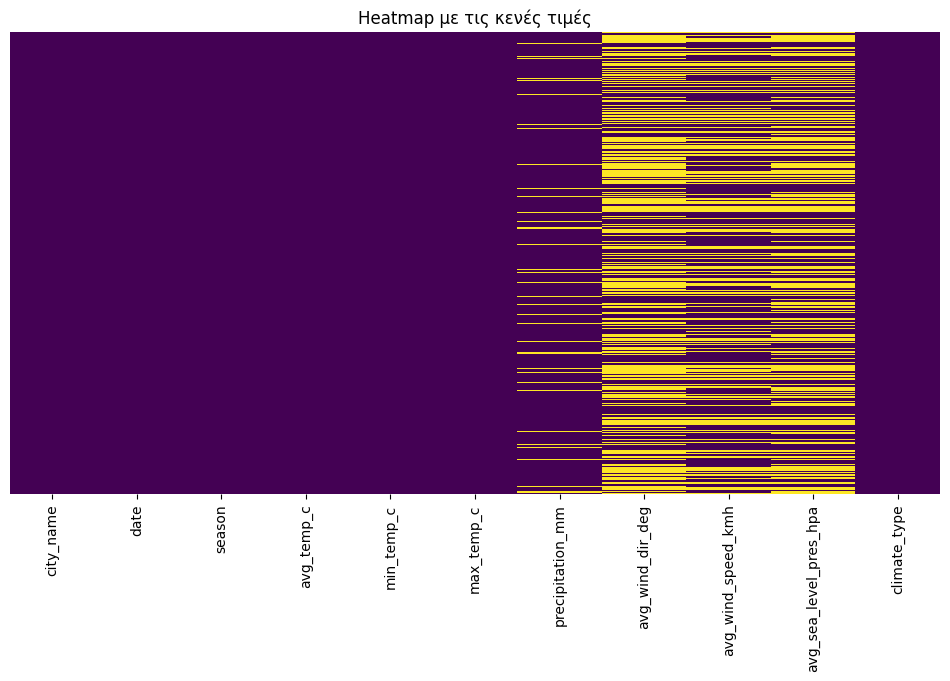

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap με τις κενές τιμές')
plt.show()

## #1 Dropping rows with missing values

In [19]:
initial_train_rows = train_data.shape[0]
initial_test_rows = test_data.shape[0]

train_data_dropped_nulls = train_data.dropna()
test_data_dropped_nulls = test_data.dropna()

final_train_rows = train_data_dropped_nulls.shape[0]
final_test_rows = test_data_dropped_nulls.shape[0]

dropped_train_rows = initial_train_rows - final_train_rows
dropped_test_rows = initial_test_rows - final_test_rows

print("Number of rows in train_data after dropping nulls: ", final_train_rows)
print("Number of rows dropped from train_data: ", dropped_train_rows)
print("Number of rows in test_data after dropping nulls: ", final_test_rows)
print("Number of rows dropped from test_data: ", dropped_test_rows)


Number of rows in train_data after dropping nulls:  541096
Number of rows dropped from train_data:  849659
Number of rows in test_data after dropping nulls:  135366
Number of rows dropped from test_data:  212323


## #2 Monthly Period Imputation  Function

### Engineering new monthly periods - approx 10secs to run

In [15]:
import calendar

def split_month(day, num_days):
    if day <= 11:
        return 'Early'
    elif day <= 21:
        return 'Mid'
    else:
        return 'Late'

train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

train_data['month_period'] = train_data['date'].apply(
    lambda x: split_month(x.day, calendar.monthrange(x.year, x.month)[1]) + ' ' + x.strftime('%B')
)

test_data['month_period'] = test_data['date'].apply(
    lambda x: split_month(x.day, calendar.monthrange(x.year, x.month)[1]) + ' ' + x.strftime('%B')
)

### Monthly period imputation function

In [16]:
folder_path_imputed = "train-test-datasets/imputed-datasets"

features = ['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm',
            'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa']

def month_period_impute(data, features, imputer, **imputer_kwargs):
    imputed_data = data.copy()
    for period in data['month_period'].unique():
        period_data = data[data['month_period'] == period]
        imp = imputer(**imputer_kwargs)
        imputed_values = imp.fit_transform(period_data[features])
        imputed_data.loc[data['month_period'] == period, features] = imputed_values
    return imputed_data

### SimpleImputer imputation method - approx 1min to run

In [17]:
from sklearn.impute import SimpleImputer

strategies = ['mean', 'median', 'most_frequent']
for strategy in strategies:
    train_data_imputed = month_period_impute(train_data, features, SimpleImputer, strategy=strategy)
    test_data_imputed = month_period_impute(test_data, features, SimpleImputer, strategy=strategy)

    train_data_imputed.to_csv(os.path.join(folder_path_imputed, f"train_data_imputed_{strategy}.csv"), index=False)
    test_data_imputed.to_csv(os.path.join(folder_path_imputed, f"test_data_imputed_{strategy}.csv"), index=False)

# Testing the different imputations

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

**Encoding non integer values + Data split + Model preparation + Model Fit + F1 score - approx 5mins to run**

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


for strategy in strategies:
    train_data = pd.read_csv(os.path.join(folder_path_imputed, f"train_data_imputed_{strategy}.csv"))
    test_data = pd.read_csv(os.path.join(folder_path_imputed, f"test_data_imputed_{strategy}.csv"))

    for column in ['season', 'month_period', 'climate_type']:
        train_data[f'{column}_encoded'] = le.fit_transform(train_data[column])
        test_data[f'{column}_encoded'] = le.transform(test_data[column])

    features_encoded = features + ['season_encoded', 'month_period_encoded']
    X_train = train_data[features_encoded]
    y_train = train_data['climate_type_encoded']
    X_test = test_data[features_encoded]
    y_test = test_data['climate_type_encoded']

    model = LogisticRegression(max_iter=1000, C=1.0, solver='saga')
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate F1 score
    f1 = round(f1_score(y_test, y_pred, average='weighted'),4)
    print(f"F1 Score for {strategy} strategy:", f1)

F1 Score for mean strategy: 0.5283
F1 Score for median strategy: 0.5344
F1 Score for most_frequent strategy: 0.5403


# Basic Plots before optimizations

Σημείωση: τα plot θα γίνουν για το **train_data_imputed_most_frequent** - το ελάχιστα καλύτερο που προέκυψε

In [19]:
train_data_imputed_mean = pd.read_csv(os.path.join(folder_path_imputed, f"train_data_imputed_mean.csv"))
train_data_imputed_median = pd.read_csv(os.path.join(folder_path_imputed, f"train_data_imputed_median.csv"))
train_data_imputed_most_frequent = pd.read_csv(os.path.join(folder_path_imputed, f"train_data_imputed_most_frequent.csv"))

## Plot #1 - Distribution Plot - Κατανομή των Μέσων Θερμοκρασιών του Καλοκαιριού σε Μεσογειακό Κλίμα

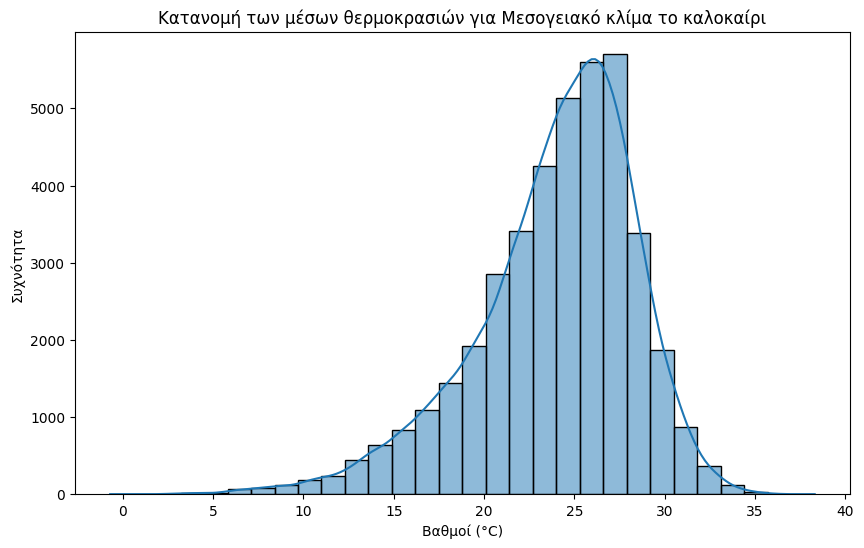

In [31]:
filtered_data = train_data_imputed_most_frequent[
    (train_data_imputed_most_frequent['climate_type'] == 'Mediterranean') &
    (train_data_imputed_most_frequent['season'] == 'Summer')
]

plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['avg_temp_c'], bins=30, kde=True)
plt.title('Κατανομή των μέσων θερμοκρασιών για Μεσογειακό κλίμα το καλοκαίρι')
plt.xlabel('Βαθμοί (°C)')
plt.ylabel('Συχνότητα')
plt.show()

## Plot #2 - Distribution Plot - Κατανομή των Μέσων precipitation_mm

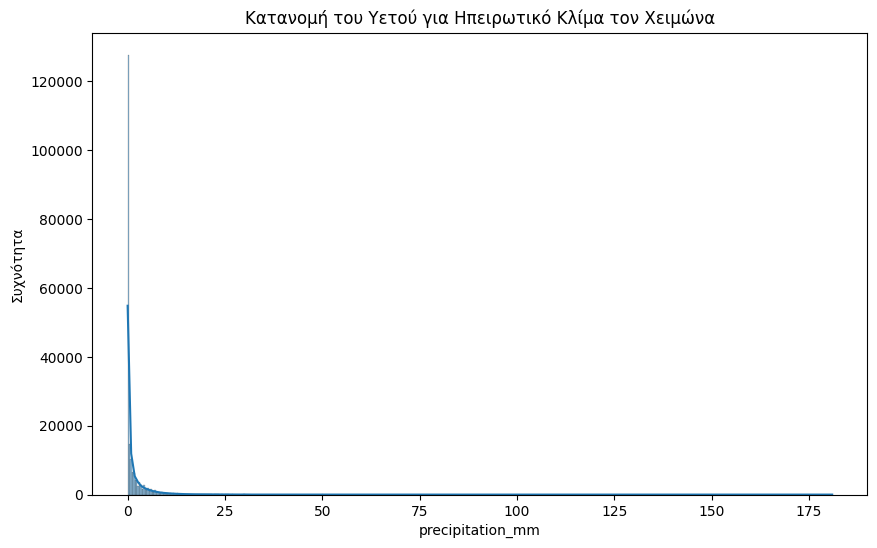

In [32]:
filtered_data = train_data_imputed_most_frequent[
    (train_data_imputed_most_frequent['climate_type'] == 'Continental') &
    (train_data_imputed_most_frequent['season'] == 'Winter')
]

plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['precipitation_mm'], bins=500, kde=True)
plt.title('Κατανομή του Υετού για Ηπειρωτικό Κλίμα τον Χειμώνα')
plt.xlabel('precipitation_mm')
plt.ylabel('Συχνότητα')
plt.show()

## Plot #3 - Pie Chart - Ποσοστά διαφορετικών τύπων κλιμάτων

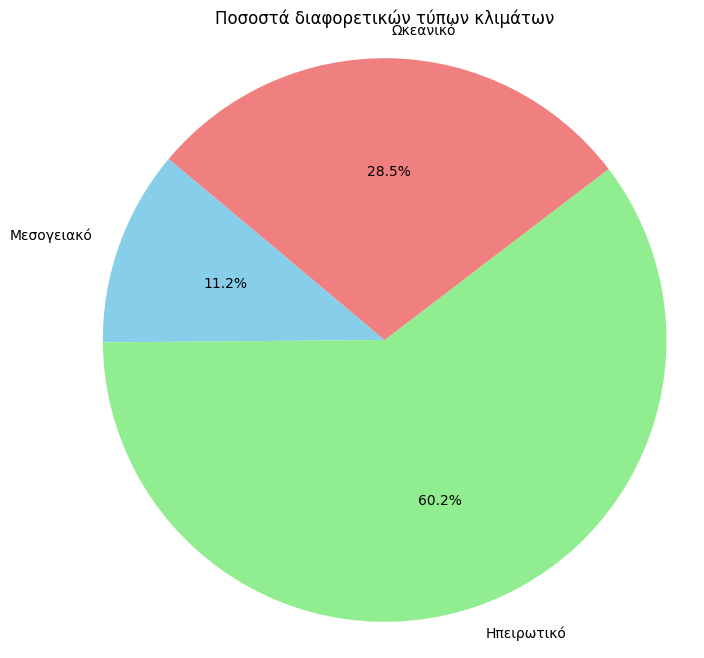

In [33]:
total_mediterranean = (train_data_imputed_most_frequent['climate_type'] == 'Mediterranean').sum()
total_continental = (train_data_imputed_most_frequent['climate_type'] == 'Continental').sum()
total_oceanic = (train_data_imputed_most_frequent['climate_type'] == 'Oceanic').sum()

total_rows = total_mediterranean + total_continental + total_oceanic

percentage_mediterranean = (total_mediterranean / total_rows) * 100
percentage_continental = (total_continental / total_rows) * 100
percentage_oceanic = (total_oceanic / total_rows) * 100

labels = ['Μεσογειακό', 'Ηπειρωτικό', 'Ωκεανικό']
sizes = [percentage_mediterranean, percentage_continental, percentage_oceanic]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'lightcoral'], startangle=140)
plt.title('Ποσοστά διαφορετικών τύπων κλιμάτων')
plt.axis('equal')
plt.show()

# Dataset Optimization

## Z-Score check for outliers

In [20]:
test_data_imputed_mean = pd.read_csv(os.path.join(folder_path_imputed, f"test_data_imputed_mean.csv"))
test_data_imputed_median = pd.read_csv(os.path.join(folder_path_imputed, f"test_data_imputed_median.csv"))
test_data_imputed_most_frequent = pd.read_csv(os.path.join(folder_path_imputed, f"test_data_imputed_most_frequent.csv"))

In [36]:
from scipy.stats import zscore
from tabulate import tabulate

def print_outlier_stats(train_data, test_data, features, threshold, strategy):
    def calculate_outliers(data):
        num_outliers = 0
        total_points = 0

        for feature in features:
            z_scores = zscore(data[feature])
            num_outliers += sum((z_scores > threshold) | (z_scores < -threshold))
            total_points += len(data)

        outlier_percentage = (num_outliers / total_points) * 100
        return num_outliers, outlier_percentage

    train_outliers, train_outlier_percentage = calculate_outliers(train_data)
    test_outliers, test_outlier_percentage = calculate_outliers(test_data)

    print("Train Data Outlier Statistics for "+strategy+":")
    print(f"Number of outliers: {train_outliers}")
    print(f"Percentage of outliers: {train_outlier_percentage:.2f}%")

    print("\nTest Data Outlier Statistics for "+strategy+":")
    print(f"Number of outliers: {test_outliers}")
    print(f"Percentage of outliers: {test_outlier_percentage:.2f}%\n")

threshold = 3
for strategy in strategies:
    train_data = globals()[f'train_data_imputed_{strategy}']
    test_data = globals()[f'test_data_imputed_{strategy}']
    print_outlier_stats(train_data, test_data, features, threshold, strategy)    

Train Data Outlier Statistics for mean:
Number of outliers: 118316
Percentage of outliers: 1.22%

Test Data Outlier Statistics for mean:
Number of outliers: 29950
Percentage of outliers: 1.23%

Train Data Outlier Statistics for median:
Number of outliers: 119439
Percentage of outliers: 1.23%

Test Data Outlier Statistics for median:
Number of outliers: 30372
Percentage of outliers: 1.25%

Train Data Outlier Statistics for most_frequent:
Number of outliers: 114683
Percentage of outliers: 1.18%

Test Data Outlier Statistics for most_frequent:
Number of outliers: 29288
Percentage of outliers: 1.20%



## Feature engineering

In [21]:
folder_path_engineered = "train-test-datasets/imputed-datasets/engineered-features"

**Feature "temp_range"**

In [22]:
def engineer_temperature_range(train_data, test_data):
    train_data['temp_range'] = train_data.apply(lambda row: row['max_temp_c'] - row['min_temp_c'], axis=1)
    test_data['temp_range'] = test_data.apply(lambda row: row['max_temp_c'] - row['min_temp_c'], axis=1)

    return train_data, test_data

**Feature "wind_vector"**

In [23]:
import numpy as np

def engineer_wind_vector(train_data, test_data):
    # Convert wind direction to radians and calculate x and y components of wind vector for train data
    train_data['wind_x'] = train_data.apply(lambda row: row['avg_wind_speed_kmh'] * np.cos(np.radians(row['avg_wind_dir_deg'])), axis=1)
    train_data['wind_y'] = train_data.apply(lambda row: row['avg_wind_speed_kmh'] * np.sin(np.radians(row['avg_wind_dir_deg'])), axis=1)
    
    # Convert wind direction to radians and calculate x and y components of wind vector for test data
    test_data['wind_x'] = test_data.apply(lambda row: row['avg_wind_speed_kmh'] * np.cos(np.radians(row['avg_wind_dir_deg'])), axis=1)
    test_data['wind_y'] = test_data.apply(lambda row: row['avg_wind_speed_kmh'] * np.sin(np.radians(row['avg_wind_dir_deg'])), axis=1)
    
    return train_data, test_data

**Binary Feature "rained"**

In [24]:
def engineer_rained(train_data, test_data):
    train_data['rained'] = train_data['precipitation_mm'].apply(lambda x: 1 if x > 0 else 0)
    test_data['rained'] = test_data['precipitation_mm'].apply(lambda x: 1 if x > 0 else 0)
    
    return train_data, test_data

**Engineering the new features - approx 3mins to run**

In [25]:
for strategy in strategies:
    train_data = globals()[f'train_data_imputed_{strategy}']
    test_data = globals()[f'test_data_imputed_{strategy}']
    engineer_temperature_range(train_data, test_data)
    engineer_wind_vector(train_data, test_data)
    engineer_rained(train_data, test_data)

    train_data.to_csv(os.path.join(folder_path_engineered, f"train_data_imputed_{strategy}_engineered.csv"), index=False)
    test_data.to_csv(os.path.join(folder_path_engineered, f"test_data_imputed_{strategy}_engineered.csv"), index=False)

**Importing the new datasets**

In [26]:
train_data_imputed_mean_engineered = pd.read_csv(os.path.join(folder_path_engineered, f"train_data_imputed_mean_engineered.csv"))
train_data_imputed_median_engineered = pd.read_csv(os.path.join(folder_path_engineered, f"train_data_imputed_median_engineered.csv"))
train_data_imputed_most_frequent_engineered = pd.read_csv(os.path.join(folder_path_engineered, f"train_data_imputed_most_frequent_engineered.csv"))

test_data_imputed_mean_engineered = pd.read_csv(os.path.join(folder_path_engineered, f"test_data_imputed_mean_engineered.csv"))
test_data_imputed_median_engineered = pd.read_csv(os.path.join(folder_path_engineered, f"test_data_imputed_median_engineered.csv"))
test_data_imputed_most_frequent_engineered = pd.read_csv(os.path.join(folder_path_engineered, f"test_data_imputed_most_frequent_engineered.csv"))

**Testing the new F1 scores**

In [27]:
features_new = ['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm',
            'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa',
            'temp_range', 'wind_x', 'wind_y','rained']

**approx 17mins to run**

In [57]:
for strategy in strategies:
    train_data = pd.read_csv(os.path.join(folder_path_engineered, f"train_data_imputed_{strategy}_engineered.csv"))
    test_data = pd.read_csv(os.path.join(folder_path_engineered, f"test_data_imputed_{strategy}_engineered.csv"))

    for column in ['season', 'month_period', 'climate_type']:
        train_data[f'{column}_encoded'] = le.fit_transform(train_data[column])
        test_data[f'{column}_encoded'] = le.transform(test_data[column])

    features_encoded = features_new + ['season_encoded', 'month_period_encoded']
    X_train = train_data[features_encoded]
    y_train = train_data['climate_type_encoded']
    X_test = test_data[features_encoded]
    y_test = test_data['climate_type_encoded']

    model = LogisticRegression(max_iter=1000, C=1.0, solver='saga')
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate F1 score
    f1 = round(f1_score(y_test, y_pred, average='weighted'),4)
    print(f"F1 Score for {strategy} strategy enginereed:", f1)

F1 Score for mean strategy enginereed: 0.5302
F1 Score for median strategy enginereed: 0.535
F1 Score for most_frequent strategy enginereed: 0.5499


## Feature Importance/Selection

## Feature Importance

### Feature importance plot for the basic model (Logistic Regression) - only for the most frequent imputation strategy - approx 4mins 20secs to run

Feature coefficients:
rained: 0.23266269581737511
avg_temp_c: -0.0914303582848789
season_encoded: -0.055869189510523436
temp_range: 0.04903767863066369
max_temp_c: 0.03135029374014473
avg_wind_speed_kmh: -0.02509059991750241
min_temp_c: -0.017687384890473824
precipitation_mm: -0.009370945554343924
wind_y: -0.006412903974826689
avg_sea_level_pres_hpa: 0.0012045038182215196
month_period_encoded: -0.0004424034657059619
wind_x: -0.00033637319638085456
avg_wind_dir_deg: 0.00021329502710396326


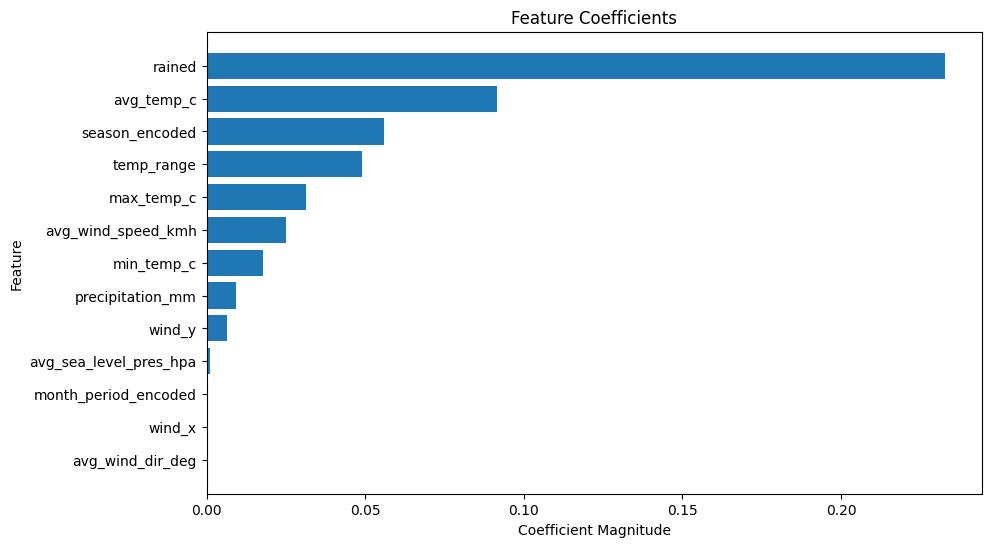

In [59]:
le = LabelEncoder()

for column in ['season', 'month_period', 'climate_type']:
    train_data_imputed_most_frequent_engineered[f'{column}_encoded'] = le.fit_transform(train_data_imputed_most_frequent_engineered[column])

features_encoded = features_new + ['season_encoded', 'month_period_encoded']

X_train = train_data_imputed_most_frequent_engineered[features_encoded]
y_train = train_data_imputed_most_frequent_engineered['climate_type_encoded']

model = LogisticRegression(max_iter=1000, C=1.0, solver='saga')
model.fit(X_train, y_train)

coefficients = model.coef_[0]

feature_coefficients = list(zip(features_encoded, coefficients))
sorted_feature_coefficients = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)

print("Feature coefficients:")
for feature, coefficient in sorted_feature_coefficients:
    print(f"{feature}: {coefficient}")

plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in sorted_feature_coefficients], [abs(x[1]) for x in sorted_feature_coefficients])
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Coefficients')
plt.gca().invert_yaxis()
plt.show()

## Feature Selection

**Feature Selection using Recursive Feature Elimination (RFE) - approx 3 hours and 4mins to run**

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

n_rows = 100000

estimator = RandomForestClassifier(n_estimators=100, random_state=42)
selector = RFE(estimator, n_features_to_select=8, step=1)

for strategy in strategies:
    train_data = pd.read_csv(os.path.join(folder_path_engineered, f"train_data_imputed_{strategy}_engineered.csv"), nrows=n_rows)
    test_data = pd.read_csv(os.path.join(folder_path_engineered, f"test_data_imputed_{strategy}_engineered.csv"), nrows=n_rows)

    for column in ['season', 'month_period', 'climate_type']:
        train_data[f'{column}_encoded'] = le.fit_transform(train_data[column])
        test_data[f'{column}_encoded'] = le.transform(test_data[column])

    features_encoded = features_new + ['season_encoded', 'month_period_encoded']
    X_train = train_data[features_encoded]
    y_train = train_data['climate_type_encoded']
    X_test = test_data[features_encoded]
    y_test = test_data['climate_type_encoded']

    selector = selector.fit(X_train, y_train)
    selected_features = X_train.columns[selector.support_]
    print(f"Selected features for {strategy}:", selected_features)

    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    model = LogisticRegression(max_iter=1000, C=1.0, solver='saga')
    model.fit(X_train_selected, y_train)

    # Make predictions
    y_pred = model.predict(X_test_selected)

    # Calculate F1 score
    f1 = round(f1_score(y_test, y_pred, average='weighted'),4)
    print(f"F1 Score for {strategy} strategy enginereed:", f1)

Selected features for mean: Index(['avg_temp_c', 'min_temp_c', 'max_temp_c', 'avg_wind_speed_kmh',
       'avg_sea_level_pres_hpa', 'temp_range', 'wind_x', 'wind_y'],
      dtype='object')
F1 Score for mean strategy enginereed: 0.5297
Selected features for median: Index(['avg_temp_c', 'min_temp_c', 'max_temp_c', 'avg_wind_speed_kmh',
       'avg_sea_level_pres_hpa', 'temp_range', 'wind_x', 'wind_y'],
      dtype='object')
F1 Score for median strategy enginereed: 0.5319
Selected features for most_frequent: Index(['avg_temp_c', 'min_temp_c', 'max_temp_c', 'avg_wind_speed_kmh',
       'avg_sea_level_pres_hpa', 'temp_range', 'wind_x', 'wind_y'],
      dtype='object')
F1 Score for most_frequent strategy enginereed: 0.5426


In [28]:
RFE_features = ['avg_temp_c', 'min_temp_c', 'max_temp_c', 'avg_wind_speed_kmh',
       'avg_sea_level_pres_hpa', 'temp_range', 'wind_x', 'wind_y']

**Feature Selection using Recursive Feature Elimination with Cross Validation (RFECV) - approx 1hour to run**

In [45]:
from sklearn.feature_selection import RFECV

n_rows = 100000

estimator = RandomForestClassifier(n_estimators=100, random_state=42)
selector = RFECV(estimator, step=1, cv=5, scoring='accuracy')

for strategy in strategies:
    train_data = pd.read_csv(os.path.join(folder_path_engineered, f"train_data_imputed_{strategy}_engineered.csv"), nrows=n_rows)
    test_data = pd.read_csv(os.path.join(folder_path_engineered, f"test_data_imputed_{strategy}_engineered.csv"), nrows=n_rows)

    for column in ['season', 'month_period', 'climate_type']:
        train_data[f'{column}_encoded'] = le.fit_transform(train_data[column])
        test_data[f'{column}_encoded'] = le.transform(test_data[column])

    features_encoded = features_new + ['season_encoded', 'month_period_encoded']
    X_train = train_data[features_encoded]
    y_train = train_data['climate_type_encoded']
    X_test = test_data[features_encoded]
    y_test = test_data['climate_type_encoded']

    selector = selector.fit(X_train, y_train)
    selected_features = X_train.columns[selector.support_]
    print(f"Selected features for {strategy}:", selected_features)

    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    model = LogisticRegression(max_iter=1000, C=1.0, solver='saga')
    model.fit(X_train_selected, y_train)

    # Make predictions
    y_pred = model.predict(X_test_selected)

    # Calculate F1 score
    f1 = round(f1_score(y_test, y_pred, average='weighted'),4)
    print(f"F1 Score for {strategy} strategy enginereed after RFECV:", f1)

Selected features for mean: Index(['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm',
       'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa',
       'temp_range', 'wind_x', 'wind_y', 'rained', 'season_encoded',
       'month_period_encoded'],
      dtype='object')
F1 Score for mean strategy enginereed after RFECV: 0.5299
Selected features for median: Index(['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm',
       'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa',
       'temp_range', 'wind_x', 'wind_y', 'rained', 'season_encoded',
       'month_period_encoded'],
      dtype='object')


c:\Users\Rafail Papastamou\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


F1 Score for median strategy enginereed after RFECV: 0.5342
Selected features for most_frequent: Index(['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm',
       'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa',
       'temp_range', 'wind_x', 'wind_y', 'season_encoded',
       'month_period_encoded'],
      dtype='object')
F1 Score for most_frequent strategy enginereed after RFECV: 0.5439


**Creating lists with the best features according to RFECV**

In [33]:
mean_features = ['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm',
       'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa',
       'temp_range', 'wind_x', 'wind_y', 'rained', 'season_encoded',
       'month_period_encoded']
median_features = ['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm',
       'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa',
       'temp_range', 'wind_x', 'wind_y', 'rained', 'season_encoded',
       'month_period_encoded']
most_frequent_features = ['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm',
       'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa',
       'temp_range', 'wind_x', 'wind_y', 'season_encoded',
       'month_period_encoded']

# Trying different models

In [32]:
feature_categories = {'initial', 'engineered', 'rfe', 'rfecv'}

## k-nearest Neighbors - approx 22mins to run

In [52]:
from sklearn.neighbors import KNeighborsClassifier

for feature_category in feature_categories:

    for strategy in strategies:
        train_data = pd.read_csv(os.path.join(folder_path_engineered, f"train_data_imputed_{strategy}_engineered.csv"))
        test_data = pd.read_csv(os.path.join(folder_path_engineered, f"test_data_imputed_{strategy}_engineered.csv"))

        for column in ['season', 'month_period', 'climate_type']:
            train_data[f'{column}_encoded'] = le.fit_transform(train_data[column])
            test_data[f'{column}_encoded'] = le.transform(test_data[column])

        if feature_category == 'initial':
            features_custom = features
        elif feature_category == 'engineered':
            features_custom = features_new
        elif feature_category == 'rfe':
            features_custom = RFE_features
        elif feature_category == 'rfecv':
            if strategy == 'mean':
                features_custom = mean_features
            elif strategy == 'median':
                features_custom = median_features
            elif strategy == 'most_frequent':
                features_custom = most_frequent_features
        
        X_train = train_data[features_custom]
        y_train = train_data['climate_type_encoded']
        X_test = test_data[features_custom]
        y_test = test_data['climate_type_encoded']

        model = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto',
            leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate F1 score
        f1 = round(f1_score(y_test, y_pred, average='weighted'),4)
        print(f"F1 Score for {strategy} strategy enginereed using the features: {feature_category} and the model: (k-nearest neighbor model):", f1)

F1 Score for mean strategy enginereed using the features: rfe and the model: (k-nearest neighbor model): 0.6312
F1 Score for median strategy enginereed using the features: rfe and the model: (k-nearest neighbor model): 0.631
F1 Score for most_frequent strategy enginereed using the features: rfe and the model: (k-nearest neighbor model): 0.5954
F1 Score for mean strategy enginereed using the features: rfecv and the model: (k-nearest neighbor model): 0.6589
F1 Score for median strategy enginereed using the features: rfecv and the model: (k-nearest neighbor model): 0.6505
F1 Score for most_frequent strategy enginereed using the features: rfecv and the model: (k-nearest neighbor model): 0.6166
F1 Score for mean strategy enginereed using the features: engineered and the model: (k-nearest neighbor model): 0.6315
F1 Score for median strategy enginereed using the features: engineered and the model: (k-nearest neighbor model): 0.6206
F1 Score for most_frequent strategy enginereed using the feat

## Random Forest Classifier - approx 116mins to run

In [53]:
from sklearn.ensemble import RandomForestClassifier

for feature_category in feature_categories:

    for strategy in strategies:
        train_data = pd.read_csv(os.path.join(folder_path_engineered, f"train_data_imputed_{strategy}_engineered.csv"))
        test_data = pd.read_csv(os.path.join(folder_path_engineered, f"test_data_imputed_{strategy}_engineered.csv"))

        for column in ['season', 'month_period', 'climate_type']:
            train_data[f'{column}_encoded'] = le.fit_transform(train_data[column])
            test_data[f'{column}_encoded'] = le.transform(test_data[column])

        if feature_category == 'initial':
            features_custom = features
        elif feature_category == 'engineered':
            features_custom = features_new
        elif feature_category == 'rfe':
            features_custom = RFE_features
        elif feature_category == 'rfecv':
            if strategy == 'mean':
                features_custom = mean_features
            elif strategy == 'median':
                features_custom = median_features
            elif strategy == 'most_frequent':
                features_custom = most_frequent_features
        
        X_train = train_data[features_custom]
        y_train = train_data['climate_type_encoded']
        X_test = test_data[features_custom]
        y_test = test_data['climate_type_encoded']

        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate F1 score
        f1 = round(f1_score(y_test, y_pred, average='weighted'),4)
        print(f"F1 Score for {strategy} strategy enginereed using the features: {feature_category} and the model: (RandomForestClassifier):", f1)

F1 Score for mean strategy enginereed using the features: rfe and the model: (RandomForestClassifier): 0.6552
F1 Score for median strategy enginereed using the features: rfe and the model: (RandomForestClassifier): 0.6533
F1 Score for most_frequent strategy enginereed using the features: rfe and the model: (RandomForestClassifier): 0.6281
F1 Score for mean strategy enginereed using the features: rfecv and the model: (RandomForestClassifier): 0.7092
F1 Score for median strategy enginereed using the features: rfecv and the model: (RandomForestClassifier): 0.7058
F1 Score for most_frequent strategy enginereed using the features: rfecv and the model: (RandomForestClassifier): 0.695
F1 Score for mean strategy enginereed using the features: engineered and the model: (RandomForestClassifier): 0.6692
F1 Score for median strategy enginereed using the features: engineered and the model: (RandomForestClassifier): 0.6625
F1 Score for most_frequent strategy enginereed using the features: engineered

## XGBooster - approx 6mins to run

In [54]:
from xgboost import XGBClassifier

for feature_category in feature_categories:

    for strategy in strategies:
        train_data = pd.read_csv(os.path.join(folder_path_engineered, f"train_data_imputed_{strategy}_engineered.csv"))
        test_data = pd.read_csv(os.path.join(folder_path_engineered, f"test_data_imputed_{strategy}_engineered.csv"))

        for column in ['season', 'month_period', 'climate_type']:
            train_data[f'{column}_encoded'] = le.fit_transform(train_data[column])
            test_data[f'{column}_encoded'] = le.transform(test_data[column])

        if feature_category == 'initial':
            features_custom = features
        elif feature_category == 'engineered':
            features_custom = features_new
        elif feature_category == 'rfe':
            features_custom = RFE_features
        elif feature_category == 'rfecv':
            if strategy == 'mean':
                features_custom = mean_features
            elif strategy == 'median':
                features_custom = median_features
            elif strategy == 'most_frequent':
                features_custom = most_frequent_features
        
        X_train = train_data[features_custom]
        y_train = train_data['climate_type_encoded']
        X_test = test_data[features_custom]
        y_test = test_data['climate_type_encoded']

        model = XGBClassifier()
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate F1 score
        f1 = round(f1_score(y_test, y_pred, average='weighted'),4)
        print(f"F1 Score for {strategy} strategy enginereed using the features: {feature_category} and the model: (XGBClassifier):", f1)

F1 Score for mean strategy enginereed using the features: rfe and the model: (XGBClassifier): 0.6618
F1 Score for median strategy enginereed using the features: rfe and the model: (XGBClassifier): 0.6606
F1 Score for most_frequent strategy enginereed using the features: rfe and the model: (XGBClassifier): 0.6395
F1 Score for mean strategy enginereed using the features: rfecv and the model: (XGBClassifier): 0.7165
F1 Score for median strategy enginereed using the features: rfecv and the model: (XGBClassifier): 0.7115
F1 Score for most_frequent strategy enginereed using the features: rfecv and the model: (XGBClassifier): 0.7063
F1 Score for mean strategy enginereed using the features: engineered and the model: (XGBClassifier): 0.6753
F1 Score for median strategy enginereed using the features: engineered and the model: (XGBClassifier): 0.6701
F1 Score for most_frequent strategy enginereed using the features: engineered and the model: (XGBClassifier): 0.6483
F1 Score for mean strategy engi

# TPOTClassifier - approx 145mins to run

In [42]:
from tpot import TPOTClassifier

train_data = pd.read_csv(os.path.join(folder_path_engineered, f"train_data_imputed_mean_engineered.csv"))
test_data = pd.read_csv(os.path.join(folder_path_engineered, f"test_data_imputed_mean_engineered.csv"))

for column in ['season', 'month_period', 'climate_type']:
    train_data[f'{column}_encoded'] = le.fit_transform(train_data[column])
    test_data[f'{column}_encoded'] = le.transform(test_data[column])

features_custom = mean_features

X_train = train_data[features_custom]
y_train = train_data['climate_type_encoded']
X_test = test_data[features_custom]
y_test = test_data['climate_type_encoded']

X_train_subset = X_train[:100000]
y_train_subset = y_train[:100000]

tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, scoring='accuracy', cv=5, random_state=42)
tpot.fit(X_train_subset, y_train_subset)

best_pipeline = tpot.fitted_pipeline_

best_pipeline.fit(X_train, y_train)

y_pred = best_pipeline.predict(X_test)

f1 = round(f1_score(y_test, y_pred, average='weighted'), 4)
print(f"F1 Score for mean strategy engineered using the features: RFECV and the model (TPOTClassifier):", f1)

                                                                                
Generation 1 - Current best internal CV score: 0.71387
                                                                               
Generation 2 - Current best internal CV score: 0.71387
                                                                                  
Generation 3 - Current best internal CV score: 0.71387
                                                                                  
Generation 4 - Current best internal CV score: 0.71387
                                                                                 
Generation 5 - Current best internal CV score: 0.7146699999999999
                                                             
Best pipeline: XGBClassifier(input_matrix, learning_rate=0.5, max_depth=7, min_child_weight=12, n_estimators=100, n_jobs=1, subsample=0.7500000000000001, verbosity=0)
F1 Score for mean strategy engineered using the features: RFECV and the mode

# Final Plots

## Future Importance Plot

Feature importance:
                   Feature  Importance
11          season_encoded    0.274577
1               min_temp_c    0.148192
0               avg_temp_c    0.126852
2               max_temp_c    0.078201
12    month_period_encoded    0.063157
3         precipitation_mm    0.060330
6   avg_sea_level_pres_hpa    0.055967
5       avg_wind_speed_kmh    0.046782
8                   wind_x    0.045156
7               temp_range    0.036913
4         avg_wind_dir_deg    0.034851
9                   wind_y    0.029023
10                  rained    0.000000


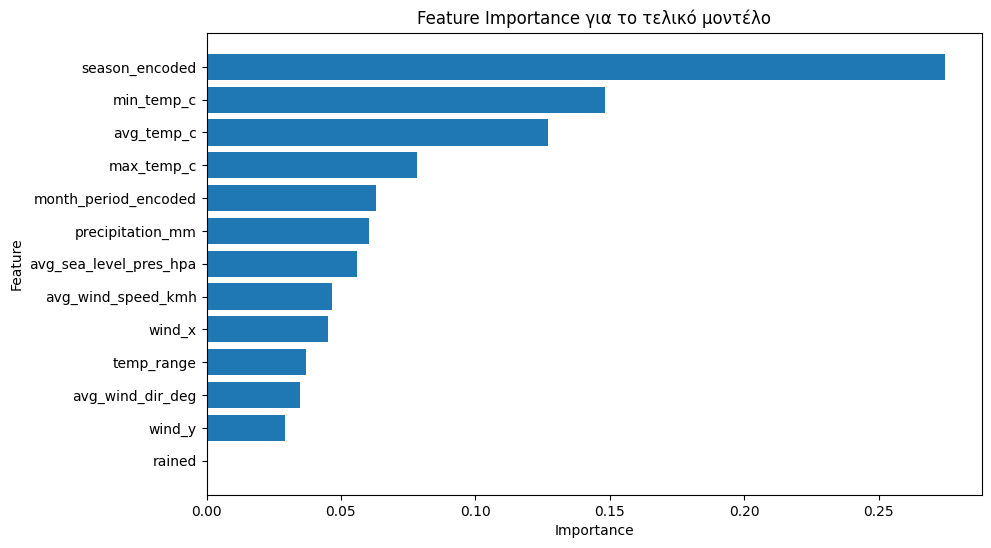

In [50]:
# Extract the XGBClassifier from the pipeline if it exists
xgb_model = None
for step in best_pipeline.steps:
    if isinstance(step[1], XGBClassifier):
        xgb_model = step[1]
        break

if xgb_model:
    importance = xgb_model.feature_importances_
    feature_names = features_custom
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("Feature importance:")
    print(feature_importance_df)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance για το τελικό μοντέλο')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("The best pipeline does not support feature importances.")

## Confusion Matrix

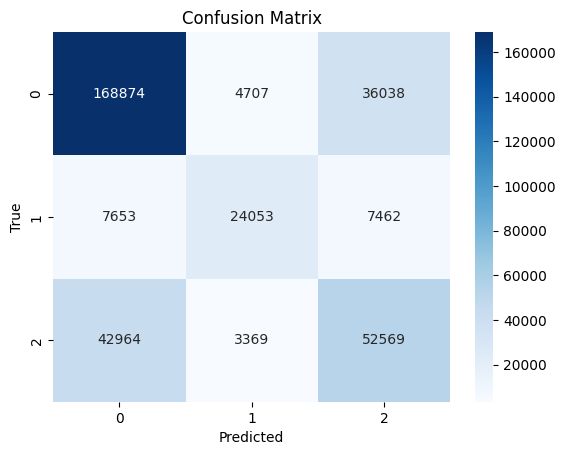

              precision    recall  f1-score   support

           0       0.77      0.81      0.79    209619
           1       0.75      0.61      0.67     39168
           2       0.55      0.53      0.54     98902

    accuracy                           0.71    347689
   macro avg       0.69      0.65      0.67    347689
weighted avg       0.70      0.71      0.70    347689

['Continental', 'Mediterranean', 'Oceanic']


In [52]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred))

print(list(le.classes_))

## Learning Curve

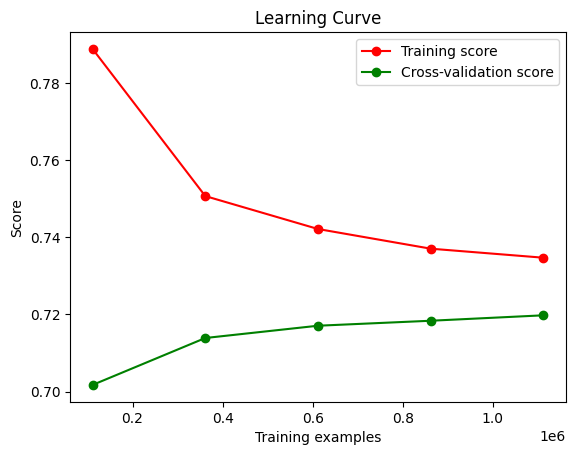

In [54]:
from sklearn.model_selection import learning_curve

# Extract the XGBClassifier from the pipeline if it exists
xgb_model = None
for step in best_pipeline.steps:
    if isinstance(step[1], XGBClassifier):
        xgb_model = step[1]
        break

if xgb_model:
    # Learning Curve
    train_sizes, train_scores, valid_scores = learning_curve(xgb_model, X_train, y_train, cv=5, scoring='f1_weighted')
    train_scores_mean = train_scores.mean(axis=1)
    valid_scores_mean = valid_scores.mean(axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, valid_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.show()
else:
    print("The best pipeline does not support learning curves.")